#Lets Generate Music using Char-RNN

## Import Section

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import argparse
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, TimeDistributed, Dense, Activation, Embedding
from tensorflow.keras.utils import plot_model


## lets pull the data

* Download data from https://abc.sourceforge.net/NMD/

In [3]:
!gdown 17OyT1kWrxFQ1sKr71B-QqWiqC1AVgbSo

Downloading...
From: https://drive.google.com/uc?id=17OyT1kWrxFQ1sKr71B-QqWiqC1AVgbSo
To: /content/input.txt
100% 130k/130k [00:00<00:00, 104MB/s]


In [4]:
!mkdir data logs models
!cp /content/input.txt /content/data/input.txt

In [5]:
with open("/content/data/input.txt") as file:
    data = file.read()

In [6]:
data

'X: 1\nT:A and D\n% Nottingham Music Database\nS:EF\nY:AB\nM:4/4\nK:A\nM:6/8\nP:A\nf|"A"ecc c2f|"A"ecc c2f|"A"ecc c2f|"Bm"BcB "E7"B2f|\n"A"ecc c2f|"A"ecc c2c/2d/2|"D"efe "E7"dcB| [1"A"Ace a2:|\n [2"A"Ace ag=g||\nK:D\nP:B\n"D"f2f Fdd|"D"AFA f2e/2f/2|"G"g2g ecd|"Em"efd "A7"cBA|\n"D"f^ef dcd|"D"AFA f=ef|"G"gfg "A7"ABc |[1"D"d3 d2e:|[2"D"d3 d2||\n\n\nX: 2\nT:Abacus\n% Nottingham Music Database\nS:By Hugh Barwell, via Phil Rowe\nM:6/8\nK:G\n"G"g2g B^AB|d2d G3|"Em"GAB "Am"A2A|"D7"ABc "G"BAG|\n"G"g2g B^AB|d2d G2G|"Em"GAB "Am"A2G|"D7"FGA "G"G3:||:\n"D7"A^GA DFA|"G"B^AB G3|"A7"^c=c^c A^ce|"D7"fef def|\n"G"g2g de=f|"E7"e2e Bcd|"Am"c2c "D7"Adc| [1"G"B2A G3:|\n [2"G"B2A G2F||"Em"E2E G2G|B2B e2e|"Am"c2A "B7"FBA|"Em"G2F E3|"Em"EFG "Am"ABc|\n"B7"B^c^d "Em"e2e|"F#7"f2f f2e|"B7"^def BAF|"Em"E2E G2G|B2B e2e|\n"Am"c2A "B7"FBA|"Em"G2F E3|"Em"EFG "Am"ABc|"B7"B^c^d "Em"e2e|\n"F#7"f2e "B7"^def |[1"Em"e3 "D7"d3:|[2"Em"e3 "E7"e3||\n\n\nX: 3\nT:The American Dwarf\n% Nottingham Music Database\nS:FTB, via EF\nM:6

In [7]:
char_to_idx = { ch: i for (i, ch) in enumerate(sorted(list(set(data)))) }
print("Number of unique characters: " + str(len(char_to_idx)))

Number of unique characters: 86


In [8]:
with open(os.path.join('/content/data', 'char_to_idx.json'), 'w') as f:
    json.dump(char_to_idx, f)

In [9]:
idx_to_char = { i: ch for (ch, i) in char_to_idx.items() }
vocab_size = len(char_to_idx)

## Lets perform batching of the data

In [28]:
batch_size = 8
sequence_length = 64

In [29]:
def read_batches(data, vocab_size):
    length = data.shape[0]; #129,665
    batch_chars = int(length / batch_size); # 8,104
    for start in range(0, batch_chars - sequence_length, sequence_length): # (0, 8040, 64)
        X = np.zeros((batch_size, sequence_length)) # 16X64
        Y = np.zeros((batch_size, sequence_length, vocab_size)) # 16X64X86
        for batch_idx in range(0, batch_size): # (0,16)
            for i in range(0, sequence_length): #(0,64)
                X[batch_idx, i] = data[batch_chars * batch_idx + start + i] # 
                Y[batch_idx, i, data[batch_chars * batch_idx + start + i + 1]] = 1
        yield X, Y


In [30]:
#Train data generation
Train_data = np.asarray([char_to_idx[c] for c in data], dtype=np.int32)

## Lets do modeling

In [31]:
model = Sequential()
model.add(Embedding(vocab_size, 512, batch_input_shape=(batch_size, sequence_length)))
for i in range(3):
    model.add(LSTM(256, return_sequences=True, stateful=True))
    model.add(Dropout(0.2))
model.add(TimeDistributed(Dense(vocab_size))) 
model.add(Activation('softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (8, 64, 512)              44032     
                                                                 
 lstm_9 (LSTM)               (8, 64, 256)              787456    
                                                                 
 dropout_9 (Dropout)         (8, 64, 256)              0         
                                                                 
 lstm_10 (LSTM)              (8, 64, 256)              525312    
                                                                 
 dropout_10 (Dropout)        (8, 64, 256)              0         
                                                                 
 lstm_11 (LSTM)              (8, 64, 256)              525312    
                                                                 
 dropout_11 (Dropout)        (8, 64, 256)             

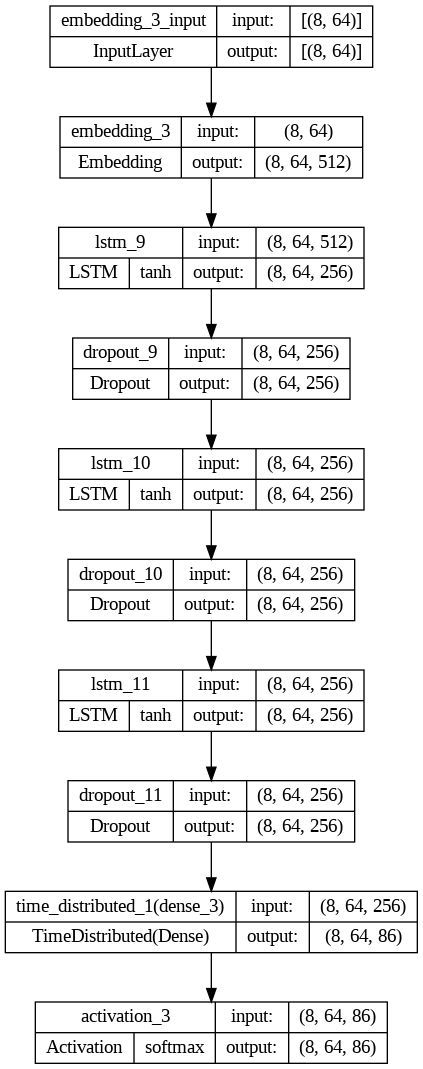

In [32]:
plot_model(model,show_shapes=True,show_layer_activations=True,show_layer_names=True)

## Lets train the model

In [33]:
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [34]:
print("Length of text:" + str(Train_data.size))

Length of text:129665


In [38]:
epochs = 250
steps_per_epoch = int((len(data) / batch_size - 1) / sequence_length  )
save_freq = 10

In [39]:
steps_per_epoch

253

In [40]:
for epoch in range(epochs):
  print('\nEpoch {}/{}'.format(epoch + 1, epochs))
  losses, accs = [], []
  for i, (X, Y) in enumerate(read_batches(Train_data, vocab_size)):     
      #print(X)
      loss, acc = model.train_on_batch(X, Y)
      #print('Batch {}: loss = {}, acc = {}'.format(i + 1, loss, acc))
      losses.append(loss)
      accs.append(acc)
  print('*'*100)
  print()
  print('epoch {}: loss = {}, acc = {}'.format(epoch + 1, np.average(losses), np.average(accs)))
  print('*'*100)
  print()
  if (epoch + 1) % save_freq == 0:
    print('#'*100)
    model.save_weights(os.path.join('/content/models/', 'weights.{}.h5'.format(epoch+1)))
    print('Saved checkpoint to', 'weights.{}.h5'.format(epoch + 1))
    print('#'*100)


Epoch 1/250
****************************************************************************************************

epoch 1: loss = 1.129946995394032, acc = 0.6330904150197628
****************************************************************************************************


Epoch 2/250
****************************************************************************************************

epoch 2: loss = 1.0888985595684277, acc = 0.6441220973320159
****************************************************************************************************


Epoch 3/250
****************************************************************************************************

epoch 3: loss = 1.0539676709608599, acc = 0.654783226284585
****************************************************************************************************


Epoch 4/250
****************************************************************************************************

epoch 4: loss = 1.016935495755418, acc = 0.6657222702

## Lets generate some sample music

## Lets rebuild model with differnt input with same weights

In [44]:
rebuilt_model = Sequential()
rebuilt_model.add(Embedding(vocab_size, 512, batch_input_shape=(1, 1)))
for i in range(3):
    rebuilt_model.add(LSTM(256, return_sequences=(i != 2), stateful=True))
    rebuilt_model.add(Dropout(0.2))
rebuilt_model.add(Dense(vocab_size))
rebuilt_model.add(Activation('softmax'))


In [63]:
rebuilt_model.load_weights('/content/models/weights.100.h5')

In [64]:
header = 'X'
sampled = [char_to_idx[c] for c in header]
print(sampled)

[51]


In [65]:
sampled = False

In [66]:
music = []
num_chars =1000
for i in range(num_chars):
  batch = np.zeros((1, 1))
  if sampled :
    batch[0, 0] = sampled[-1]
  else:
    batch[0, 0] = np.random.randint(vocab_size)
  result = rebuilt_model.predict_on_batch(batch).ravel()
  sample = np.random.choice(range(vocab_size), p=result)
  music.append(sample)
print('*'*100)
print()
print(''.join(idx_to_char[c] for c in music))
print()
print('*'*100)

****************************************************************************************************

ovotMMt 
bTFa
%GA D
isAeopautab%a% Psss Iia lteooriof )
oonts  K
toier

TTCo  Nii(hiioK::Ibr4


AA|FD| 2f|2A2/cB/3/3 dBc 11dAd c7"E|||

"2"":P4/ddBBbbdB|e
E"||4 BrnoesCrr oooa PiIsuavieNiutile    boetPa%%A
cotttroooaiss %
%%::      3oiIct 
v
oe
slo
  Notttttlooge
oovooee



raaraa  t oogeDooeo%oM us vuot   ro
To Gooroosso or
 MoNoooclooauw
a/4
::6//    6 :6A PA

||"DBoMGTognpoooepDoo:C8BDFc2|"B"|A"|2BA  
 od aa,18,n
    BoBt

es  ea1/I8
  |B  rk  cs  oc, ovaac, I ase  s ooa%od

%ll
ose

a a aaarl  %%Wob  

e
i




oooo

%%%

 %ao b 1  22|
A  |      
F2334
Tielspoa

% r aoiatAt
|%AA
T1A B

32||A/4
:DeooooDueaes otSuiea
utthen Farr

d laaa a las e
m%G, 2DAGD
c||2|||Ag|""
2/33f
'aortrrre orc



e%g   % aN oocec




 s

om


  NoPooaAA   Iooorob 
   %  Noi eosoog




%    o  % g
ovaaeas foaaa
a



: IDIooD
a  a ae
v
G 
%::T /4 TIDDDM:// B4M:ACiiruen ortsern



%I oev%Ta:A :G



T
:9

:,: 6